## MSD vs tau fitting for the whole trajectory and running window analysis

## whole trajectory analysis MSD vs tau fit

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tkinter import filedialog, Tk
import re
from math import ceil

sns.set(color_codes=True, style="white")

In [14]:
# Function to select a file
def select_file():
    root = Tk()
    root.withdraw()
    csv_file_path = filedialog.askopenfilename(
        title="Select CSV File",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
    )
    return csv_file_path

In [15]:
# Function to parse list strings into actual lists of floats
def parse_list_column(column_value):
    # Remove brackets and then split by commas
    return list(map(float, column_value[1:-1].split(', ')))

In [16]:
# Function to plot log(MSD) vs. log(tau) and calculate alpha
def plot_log_msd_vs_log_tau(df_track, trackID):
    # Parse list strings into actual lists of floats
    lags_phys = parse_list_column(df_track['list_of_tau_s'].iloc[0])
    MSDs_phys = parse_list_column(df_track['list_of_MSD_um2'].iloc[0])
    
    # Convert to log values
    log_lags = np.log10(lags_phys)
    log_MSDs = np.log10(MSDs_phys)

    # print(f"log_lags: {log_lags}")
    # print(f"log_MSDs: {log_MSDs}")
    
    # Linear regression on log values
    slope, intercept, r_value, _, _ = stats.linregress(log_lags, log_MSDs)
    alpha = slope
    R2 = r_value**2  # Coefficient of determination

    # Plot log-log MSD vs. tau
    plt.figure(figsize=(6, 4))
    plt.plot(log_lags, log_MSDs, 'o', label='MSD')
    plt.plot(log_lags, slope * log_lags + intercept, 'r-', label=f'Fit: slope = {alpha:.2f}, $R^2$ = {R2:.2f}')
    
    plt.annotate(f'trackID: {trackID}', xy=(0.05, 0.775), xycoords='axes fraction', fontsize=12,
                 horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=1))
    
    # Customize and annotate the plot
    plt.xlabel(r'$\log(\tau / s)$', fontsize=18)
    plt.ylabel(r'$\log(\text{MSD} / \mu m^2)$', fontsize=18)
    plt.xlim(0, 2.5)
    plt.xticks(np.arange(0, 2.5, 0.5))
    
    plt.gca().spines[:].set_linewidth(1)  # Customize spines
    plt.gca().tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    plt.gca().set_axisbelow(False)

    legend = plt.legend()
    legend.get_frame().set_linewidth(0)  # Remove legend box

    # Final layout adjustments
    plt.tight_layout()
    plt.show()

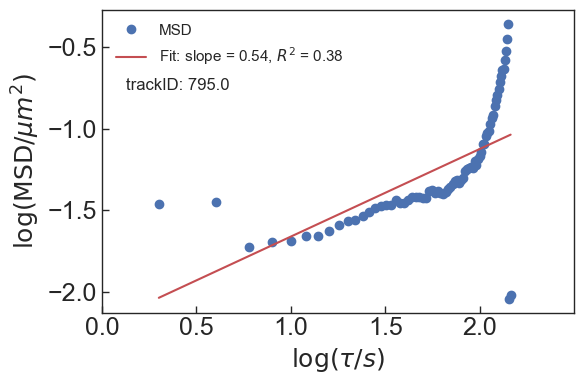

In [19]:
# Main function to execute the script
def main():
    file_path = select_file()
    df_processed = pd.read_csv(file_path)
    
    # Filter tracks with loglog_fit_R2 < 0.5
    filtered_tracks = df_processed[df_processed['loglog_fit_R2'] < 0.5]

    if not filtered_tracks.empty:
        chosen_track = filtered_tracks.sample()  # Randomly select one track
        trackID = chosen_track["trackID"].iloc[0]
        plot_log_msd_vs_log_tau(chosen_track, trackID)
    else:
        print("No tracks found with loglog_fit_R2 < 0.5.")

# Execute the main function
if __name__ == "__main__":
    main()

## Running window MSD vs tau fit for the first window

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tkinter import filedialog, Tk
import re
from math import ceil
import seaborn as sns

# Set Seaborn style
sns.set(color_codes=True, style="white")

In [22]:
# Function to select a file
def select_file():
    root = Tk()
    root.withdraw()
    csv_file_path = filedialog.askopenfilename(
        title="Select CSV File",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
    )
    return csv_file_path

In [23]:
# Function to parse list strings into actual lists of floats
def parse_list_column(column_value):
    # Remove brackets and then split by commas
    return list(map(float, column_value[1:-1].split(', ')))

In [24]:
# Function to calculate the MSD for non-physical units
def calc_MSD_NonPhysUnit(track_data, lags):
    Xs = track_data["x"].to_numpy()
    Ys = track_data["y"].to_numpy()

    MSDs = []
    for lag in lags:
        displacements = (Xs[:-lag] - Xs[lag:]) ** 2 + (Ys[:-lag] - Ys[lag:]) ** 2
        valid_displacements = displacements[~np.isnan(displacements)]
        MSD = np.nanmean(valid_displacements)
        MSDs.append(MSD)

    return np.array(MSDs, dtype=float)

In [25]:
# Function to perform running window analysis for the first window only
def running_window_analysis_first_window(df_track, trackID, window_size=5, s_per_frame=2, um_per_pixel=0.117):
    plt.figure(figsize=(6, 4))

    # Analyze only the first window's results
    start = 0
    end = start + window_size
    df_window = df_track.iloc[start:end]

    number_lag = ceil(window_size / 2)
    window_msd = calc_MSD_NonPhysUnit(df_window, np.arange(1, number_lag + 1))

    if np.sum(window_msd <= 0) > 0:
        print("Invalid MSD values in the first window")
    else:
        # Plot MSD against time for the first window
        lags = np.arange(1, number_lag + 1) * s_per_frame
        MSDs_phys = window_msd * (um_per_pixel**2)  # um^2
        
        log_lags = np.log10(lags)
        log_MSDs = np.log10(MSDs_phys)
        
        # Print log_lags and log_MSDs for verification
        print(f"log_lags (window): {log_lags}")
        print(f"log_MSDs (window): {log_MSDs}")

        plt.plot(log_lags, log_MSDs, 'o', label='MSD (Window 1)')
        slope, intercept, r_value, _, _ = stats.linregress(log_lags, log_MSDs)
        plt.plot(log_lags, slope * log_lags + intercept, 'r-', label=f'Fit (Window 1): slope = {slope:.2f}, $R^2$ = {r_value**2:.2f}')
        
        # Include trackID inside the plot
        plt.annotate(f'trackID: {trackID}', xy=(0.05, 0.76), xycoords='axes fraction', fontsize=12,
                     horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

        # Customize and annotate the plot
        plt.xlabel(r'$\log(\tau / s)$', fontsize=18)
        plt.ylabel(r'$\log(\text{MSD} / \mu m^2)$', fontsize=18)
        
        plt.gca().spines[:].set_linewidth(1)
        plt.gca().tick_params(
            axis="both",
            which="major",
            labelsize=18,
            direction="in",
            bottom=True,
            left=True,
            length=5,
            width=1,
        )
        plt.gca().set_axisbelow(False)
        
        legend = plt.legend()
        legend.get_frame().set_linewidth(0)  # Remove legend box

        plt.tight_layout()
        plt.show()

log_lags (window): [0.30103    0.60205999 0.77815125]
log_MSDs (window): [-2.91057572 -2.59512482 -2.2417717 ]


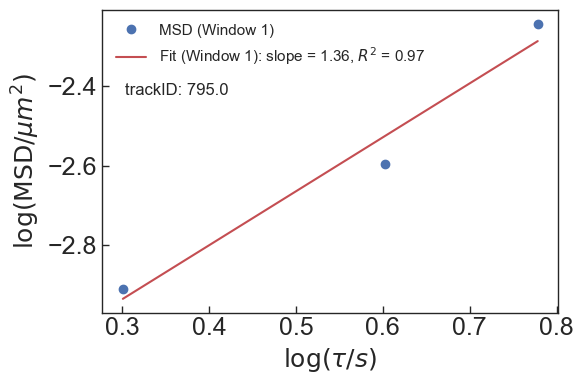

In [26]:
def main():
    # Select file and load the processed data
    file_path = select_file()
    df_processed = pd.read_csv(file_path)

    # Look for the specific trackID (795.0)
    trackID_number = 795.0
    chosen_track = df_processed[df_processed['trackID'] == trackID_number]

    if not chosen_track.empty:
        trackID = chosen_track["trackID"].iloc[0]
        # Prepare DataFrame for running window analysis
        df_track = pd.DataFrame({
            "x": parse_list_column(chosen_track['list_of_x'].iloc[0]),
            "y": parse_list_column(chosen_track['list_of_y'].iloc[0]),
            "t": parse_list_column(chosen_track['list_of_t'].iloc[0])
        })
        # Perform running window analysis
        running_window_analysis_first_window(df_track, trackID)
    else:
        print(f"No track found with trackID: {trackID_number}")

if __name__ == "__main__":
    main()

## Running window MSD vs tau fit for 5 randomly selected wiindows

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tkinter import filedialog, Tk
import re
from math import ceil
import random
import seaborn as sns

# Set Seaborn style
sns.set(color_codes=True, style="white")

In [2]:
# Function to select a file
def select_file():
    root = Tk()
    root.withdraw()
    csv_file_path = filedialog.askopenfilename(
        title="Select CSV File",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
    )
    return csv_file_path

In [3]:
# Function to parse list strings into actual lists of floats
def parse_list_column(column_value):
    # Remove brackets and then split by commas
    return list(map(float, column_value[1:-1].split(', ')))

In [4]:
# Function to calculate the MSD for non-physical units
def calc_MSD_NonPhysUnit(track_data, lags):
    Xs = track_data["x"].to_numpy()
    Ys = track_data["y"].to_numpy()

    MSDs = []
    for lag in lags:
        displacements = (Xs[:-lag] - Xs[lag:]) ** 2 + (Ys[:-lag] - Ys[lag:]) ** 2
        valid_displacements = displacements[~np.isnan(displacements)]
        MSD = np.nanmean(valid_displacements)
        MSDs.append(MSD)

    return np.array(MSDs, dtype=float)

In [5]:
# Function to perform running window analysis and store results
def running_window_analysis(chosen_track, trackID, window_size=5, s_per_frame=2, um_per_pixel=0.117):
    df_track = pd.DataFrame({
        "x": parse_list_column(chosen_track['list_of_x'].iloc[0]),
        "y": parse_list_column(chosen_track['list_of_y'].iloc[0]),
        "t": parse_list_column(chosen_track['list_of_t'].iloc[0])
    })

    step_size = 1
    msd_results = []

    for start in range(0, len(df_track) - window_size + 1, step_size):
        end = start + window_size
        df_window = df_track.iloc[start:end]

        number_lag = ceil(window_size / 2)
        if number_lag < 3:
            number_lag = 3
        window_msd = calc_MSD_NonPhysUnit(df_window, np.arange(1, number_lag + 1))

        if np.sum(window_msd <= 0) > 0:
            # Skip this window since it contains invalid MSD values
            continue
                
        # Store results for the window:
        lags = np.arange(1, number_lag + 1) * s_per_frame
        MSDs_phys = window_msd * (um_per_pixel**2) # um^2
        msd_results.append((start, lags, MSDs_phys))

    return msd_results

In [8]:
def plot_random_msd_logs(msd_results, trackID, num_plots=5):
    # Randomly select 5 windows
    random_windows = random.sample(msd_results, min(num_plots, len(msd_results)))
    
    # Create separate plots for each window
    for window_info in random_windows:
        window_num, lags, MSDs_phys = window_info
        log_lags = np.log10(lags)
        log_MSDs = np.log10(MSDs_phys)

        plt.figure(figsize=(6, 4))
        
        slope, intercept, r_value, _, _ = stats.linregress(log_lags, log_MSDs)

        plt.plot(log_lags, log_MSDs, 'o', label=f'MSD (Window {window_num})')
        plt.plot(log_lags, slope * log_lags + intercept, 'r-',
                 label=f'Fit (Window {window_num}): slope = {slope:.2f}, $R^2$ = {r_value**2:.2f}')
        
        # Include trackID inside the plot
        plt.annotate(f'trackID: {trackID}', xy=(0.05, 0.76), xycoords='axes fraction', fontsize=12,
                     horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

        # Customize and annotate the plot
        plt.xlabel(r'$\log(\tau / s)$', fontsize=18)
        plt.ylabel(r'$\log(\text{MSD} / \mu m^2)$', fontsize=18)
        
        plt.gca().spines[:].set_linewidth(1)
        plt.gca().tick_params(
            axis="both",
            which="major",
            labelsize=18,
            direction="in",
            bottom=True,
            left=True,
            length=5,
            width=1,
        )
        plt.gca().set_axisbelow(False)
        
        legend = plt.legend()
        legend.get_frame().set_linewidth(0)  # Remove legend box

        plt.tight_layout()
        plt.show()

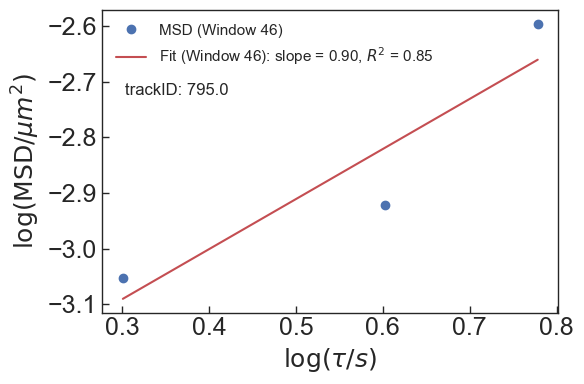

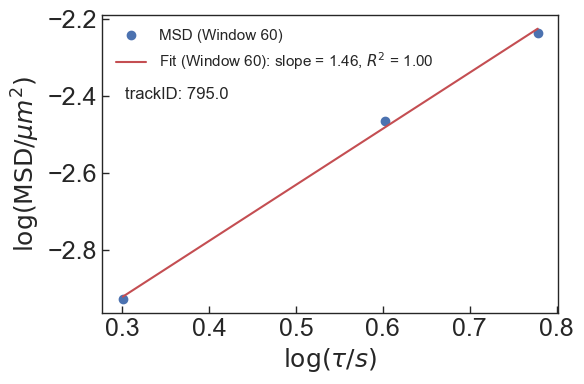

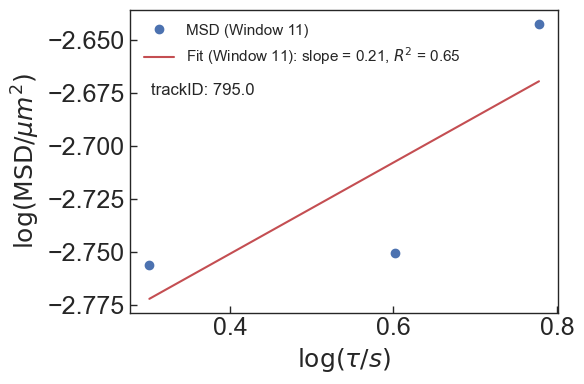

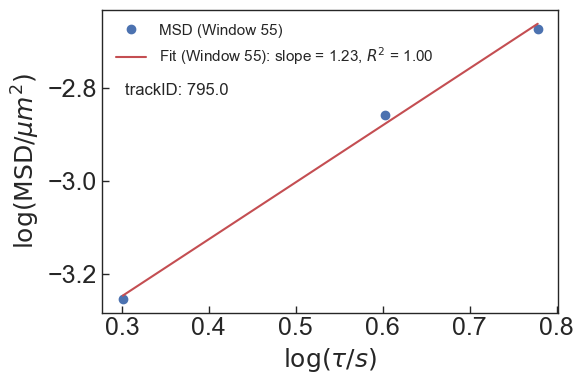

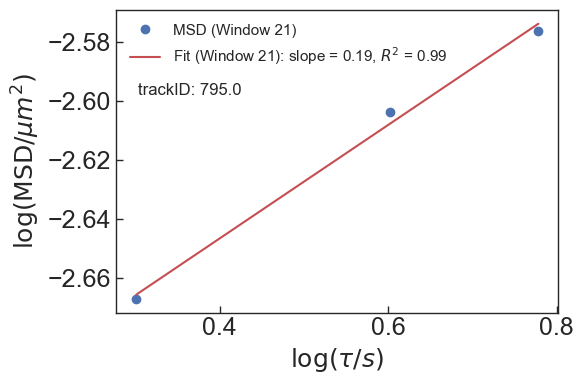

In [9]:
def main():
    # Select file and load the processed data
    file_path = select_file()
    df_processed = pd.read_csv(file_path)

    # Look for the specific trackID (795.0)
    trackID_number = 795.0
    chosen_track = df_processed[df_processed['trackID'] == trackID_number]

    if not chosen_track.empty:
        trackID = chosen_track["trackID"].iloc[0]
        # Perform running window analysis
        msd_results = running_window_analysis(chosen_track, trackID)
        # Plot 5 random log(MSD) vs log(lag) plots
        plot_random_msd_logs(msd_results, trackID, num_plots=5)
    else:
        print(f"No track found with trackID: {trackID_number}")

if __name__ == "__main__":
    main()